In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import itertools

import regreg.api as rr

from selectinf.group_lasso_query import (group_lasso, split_group_lasso)

from selectinf.Simulation.instance import logistic_group_instance

from selectinf.Simulation.test_logistic_group_lasso import (calculate_F1_score,
                                                            naive_inference,
                                                            randomization_inference,
                                                            randomization_inference_fast,
                                                            split_inference, data_splitting)

In [22]:
def logistic_p_val(range):
    """
        Compare to R randomized lasso
        """
    n = 500
    p = 20
    signal_fac = 0
    sigma = 2
    rho = 0.5
    proportion = 0.5
    randomizer_scale = 1.
    full_dispersion = True
    level = 0.90

    # Operating characteristics
    oper_char = {}
    oper_char["proportion"] = []
    oper_char["n"] = []
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    
    pvals_MLE = []
    pvals_Naive = []
    
    for n in [500]:#[200, 350, 500]:
        for proportion in [0.7]:#[0.5, 0.6, 0.7]:
        #for proportion in [0.3, 0.4, 0.5, 0.6, 0.7]:  # [0.01, 0.03, 0.06, 0.1]:
            for i in range:
                np.random.seed(i)
    
                inst, const, const_split = logistic_group_instance, group_lasso.logistic, \
                                           split_group_lasso.logistic
                signal = np.sqrt(signal_fac * 2 * np.log(p))
    
                while True:  # run until we get some selection
                    groups = np.arange(5).repeat(4)
                    X, Y, beta = inst(n=n,
                                      p=p,
                                      signal=signal,
                                      sgroup=0,
                                      groups=groups,
                                      ndiscrete=5,
                                      nlevels=5,
                                      sdiscrete=2,  # s-3, # How many discrete rvs are not null
                                      equicorrelated=False,
                                      rho=rho,
                                      random_signs=True)[:3]
                    # print(X)
    
                    n, p = X.shape
    
                    noselection = False  # flag for a certain method having an empty selected set
    
                    if not noselection:
                        # MLE inference
                        (coverage, length, beta_target, nonzero,
                         conf_low, conf_up, p_MLE) = \
                            randomization_inference_fast(X=X, Y=Y, n=n, p=p, 
                                                         proportion=proportion,
                                                         beta=beta, groups=groups,
                                                         p_val=True)
                        noselection = (coverage is None)
    
                    if not noselection:
                        # naive inference
                        (coverage_naive, lengths_naive, nonzero_naive,
                         conf_low_naive, conf_up_naive, beta_target_naive,
                         p_naive) = \
                            naive_inference(X=X, Y=Y, groups=groups,
                                            beta=beta, const=const,
                                            n=n, level=level, p_val=True)
                        noselection = (coverage_naive is None)
    
                    if not noselection:
                        # MLE coverage
                        oper_char["n"].append(n)
                        oper_char["proportion"].append(proportion)
                        oper_char["coverage rate"].append(np.mean(coverage))
                        oper_char["avg length"].append(np.mean(length))
                        oper_char["method"].append('MLE')
    
                        # Naive coverage
                        oper_char["n"].append(n)
                        oper_char["proportion"].append(proportion)
                        oper_char["coverage rate"].append(np.mean(coverage_naive))
                        oper_char["avg length"].append(np.mean(lengths_naive))
                        oper_char["method"].append('Naive')
                        
                        pvals_MLE.append(list(p_MLE))
                        pvals_Naive.append(list(p_naive))
    
                        break  # Go to next iteration if we have some selection
    
    pvals_MLE = list(itertools.chain.from_iterable(pvals_MLE))
    pvals_Naive = list(itertools.chain.from_iterable(pvals_Naive))
    
    oper_char_df = pd.DataFrame.from_dict(oper_char)
    return oper_char_df, pvals_MLE, pvals_Naive

In [33]:
oper_char_df, pvals_MLE, pvals_Naive = logistic_p_val(range(0,500))

Naive selection [0]
Naive selection [1]
Naive selection [1]
Naive selection [0, 2, 4]
Naive selection [4]
Naive selection [0, 1, 2]
Naive selection []
Naive selection [0, 2, 3]
Naive selection [0, 2, 4]
Naive selection [0, 1, 3, 4]
Naive selection [1]
Naive selection [2]
Naive selection [0, 1]
Naive selection [1]
Naive selection [2, 4]
Naive selection [0, 3]
Naive selection [0]
Naive selection [0]
Naive selection [2]
Naive selection [0, 1]
Naive selection [0, 4]
Naive selection [1]
Naive selection [2]
Naive selection [2, 3]
Naive selection [0]
Naive selection [0]
Naive selection [0]
Naive selection [0, 4]
Naive selection [2]
Naive selection []
Naive selection [3]
Naive selection [2]
Naive selection [2, 3]
Naive selection []
Naive selection [4]
Naive selection []
Naive selection [3]
Naive selection [1, 3]
Naive selection [0, 1, 2]
Naive selection [1, 3]
Naive selection [1, 2]
Naive selection [0, 2]
Naive selection [3, 4]
Naive selection []
Naive selection [0]
Naive selection [1, 2]
Naiv

In [67]:
def plot_pvals(pvals1, pvals2, title):
    plt.figure(figsize=(6,6), dpi=800)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k',
             lw=1, scalex=False, scaley=False)
    plt.plot(np.sort(pvals1), 
             np.linspace(0, 1, len(pvals1), endpoint=False), color='red',
             label="Naive")
    plt.plot(np.sort(pvals2), 
             np.linspace(0, 1, len(pvals2), endpoint=False), color="#006600",
             label="Post-GL")
    plt.legend()
    plt.title(title)

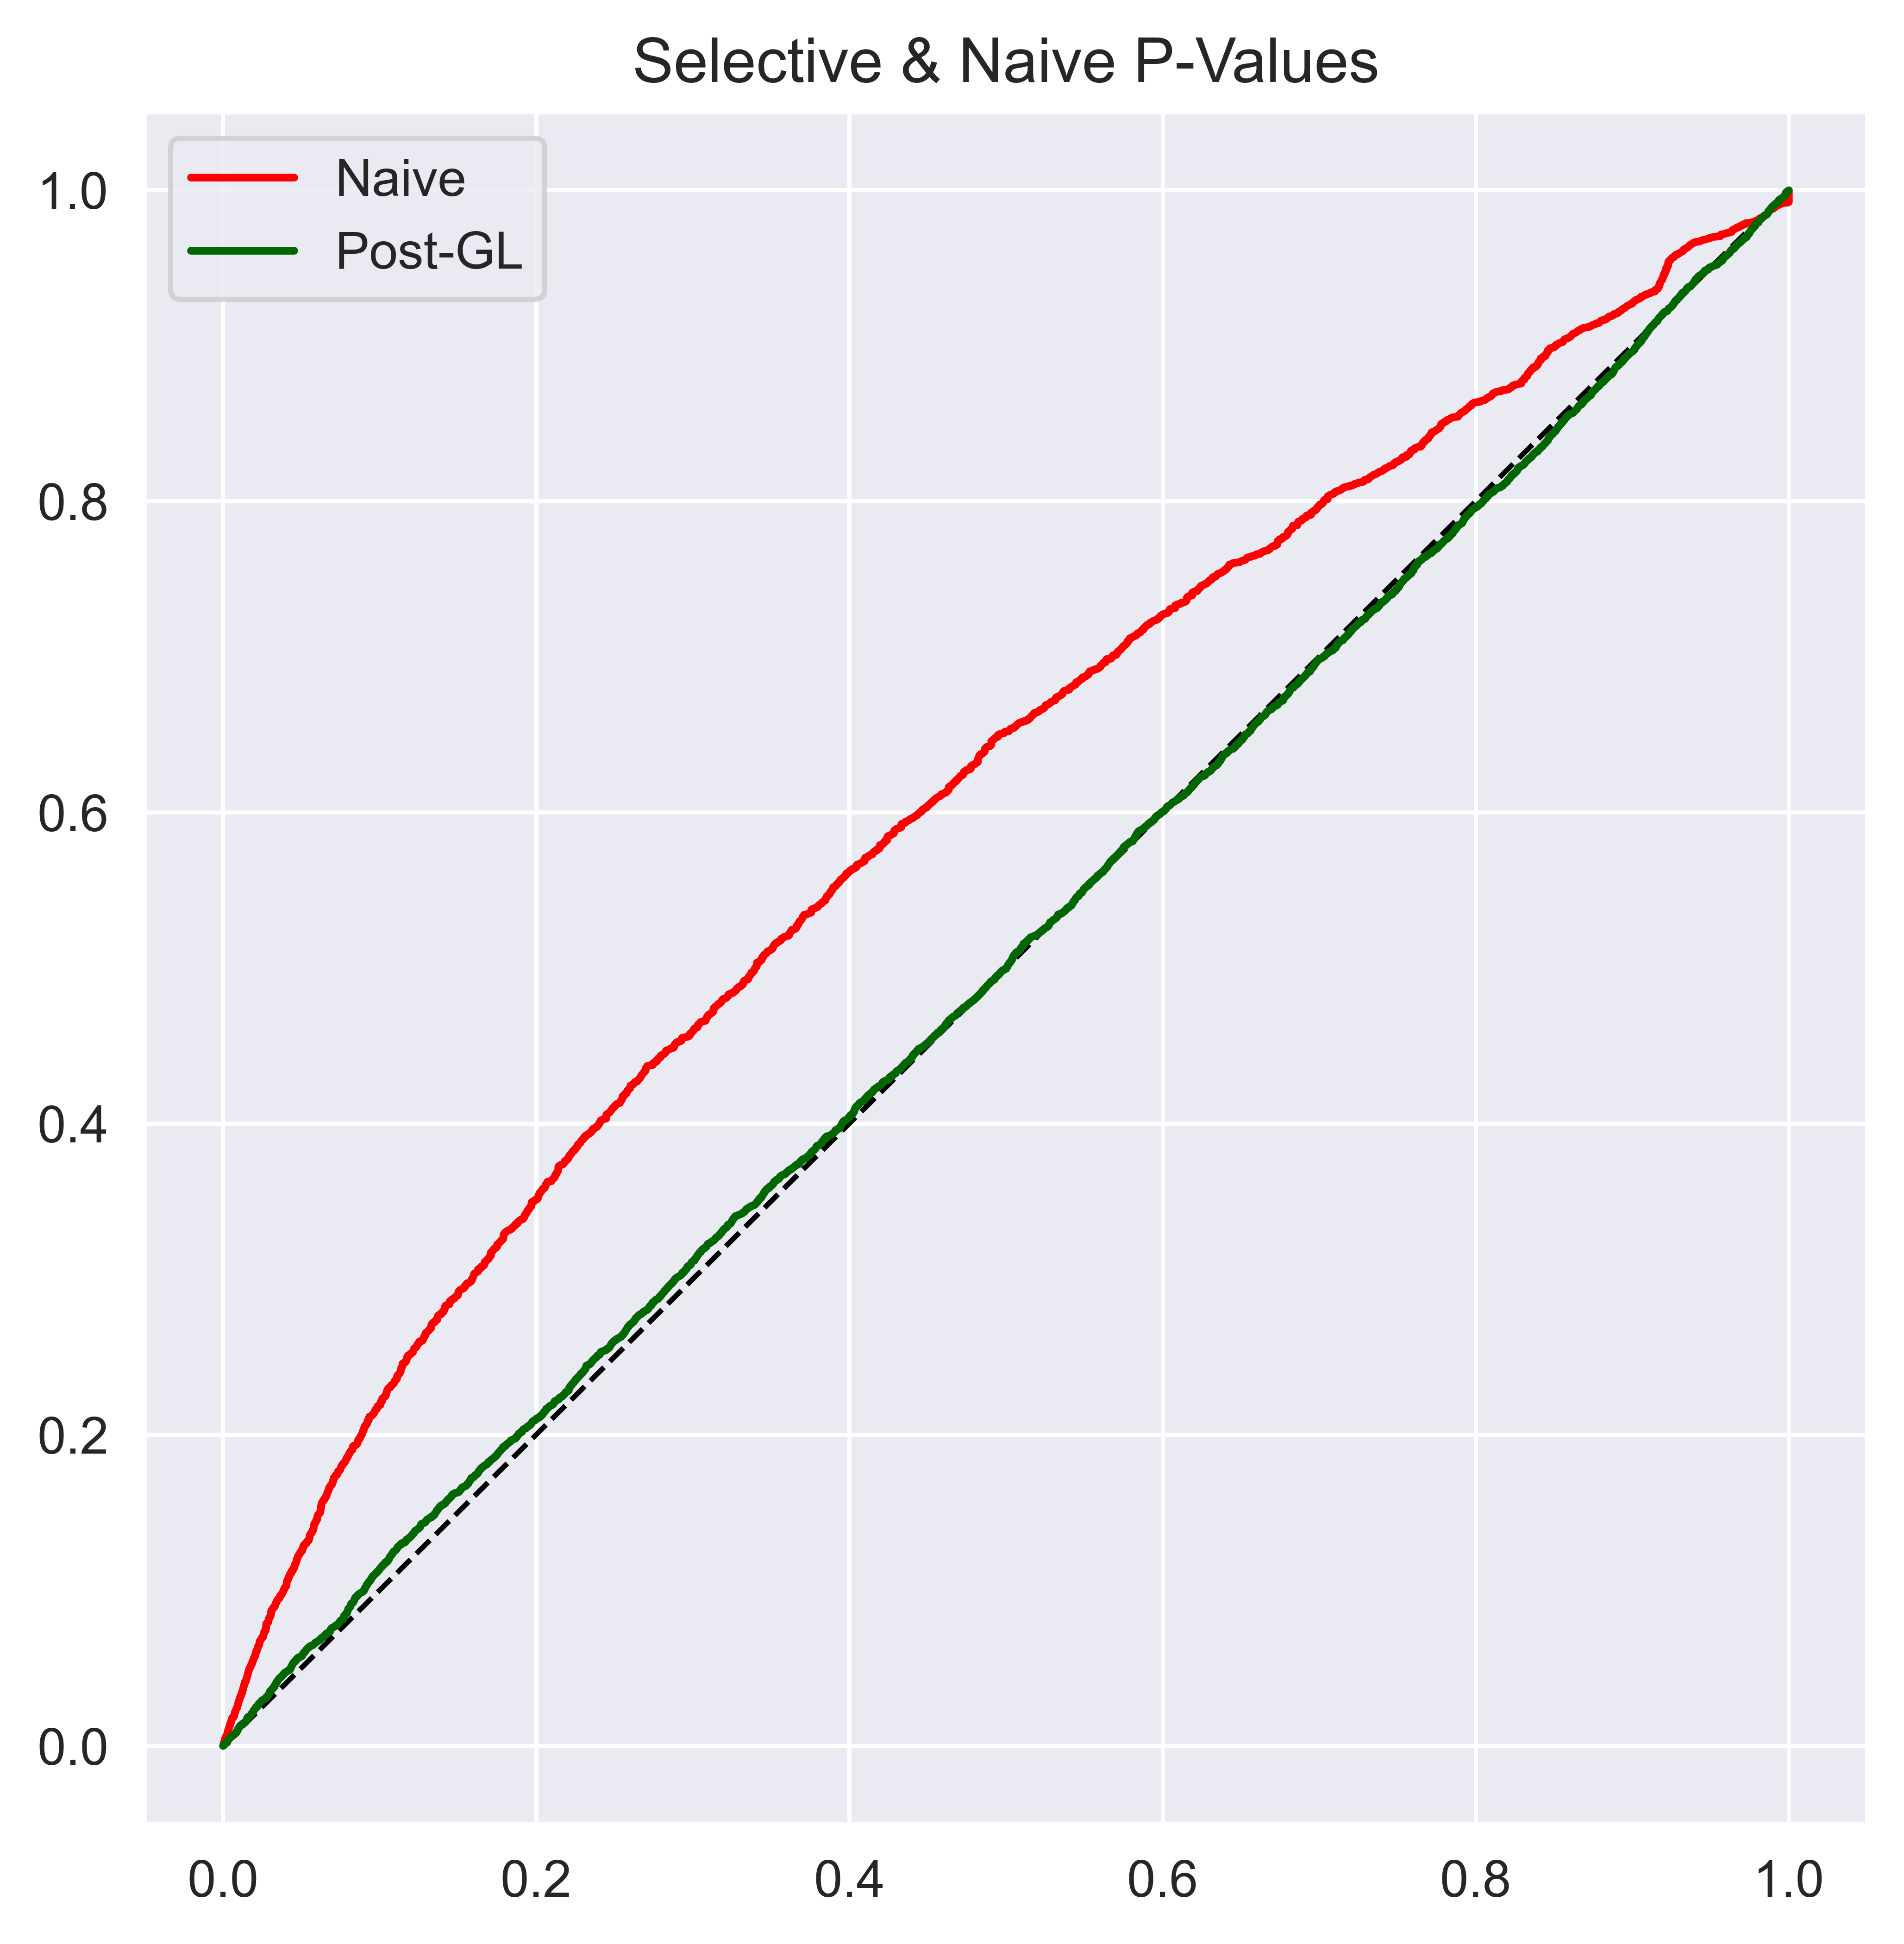

In [68]:
plot_pvals(pvals_Naive, pvals_MLE, "Selective & Naive P-Values")